In [164]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import MaxNLocator
import numpy as np
from scipy.linalg import svd

In [214]:
pd.options.display.max_rows = 11
df = pd.read_csv("rte.standardized.tsv", delimiter="\t", quotechar='"')
#rd = rd.iloc[1: , :]
df = df.drop('!amt_annotation_ids', axis=1)
#print(df)
for index, row in df.iterrows():
    if row['response'] == 0: df.at[index,'response'] = -1
    if row['gold'] == 0: df.at[index,'gold'] = -1
print(df)

     !amt_worker_ids  orig_id  response  gold
0     A19IBSKBTABMR3      266         1     1
1      AEX5NCH03LWSG      266         1     1
2     A17RPF5ZMO75GW      266         1     1
3     A15L6WGIK3VU7N      266        -1     1
4     A3U7T47F498T1P      266         1     1
...              ...      ...       ...   ...
7995  A17HNBZF5A1CWF      605         1     1
7996  A11GX90QFWDLMM      605        -1     1
7997  A1Q4VUJBMY78YR      605         1     1
7998  A1CP0KZJS5LSIF      605         1     1
7999  A1ZVGUVI9TAZJX      605         1     1

[8000 rows x 4 columns]


In [215]:
def sampling(df, k):
    tasks = df.groupby('orig_id')
    
    column_names = ["!amt_worker_ids", "orig_id", "response", "gold"]

    row_list = []
    for groupName in tasks.groups.keys():
        task = tasks.get_group(groupName)
        lables = set([0,1,2,3,4,5,6,7,8,9])
        pick = random.sample([*lables], k=k)
        for lable in pick:
            dic = {'!amt_worker_ids': task.iloc[lable, 0],
                   'orig_id': task.iloc[lable, 1],
                   'response': task.iloc[lable, 2],
                   'gold': task.iloc[lable, 3]
                  }
            row_list.append(dic)
    newDf = pd.DataFrame(row_list)
    return newDf

In [216]:
def getSvdError(df):
    tasks = df.orig_id.unique()
    workers = df['!amt_worker_ids'].unique()
    
    # get tasks-workers matrix
    tasks_workers = pd.DataFrame(index = tasks, columns = workers)
    indexs = list(tasks_workers.index) # This is for validation
    
    for index, row in df.iterrows():
        worker = row['!amt_worker_ids']
        task = row['orig_id']
        tasks_workers.at[task, worker] = row['response']
        # fill all missing data with 0
        tasks_workers = tasks_workers.fillna(0)
    
    # Choose worker 1
    worker1 = np.array(list(tasks_workers['A19IBSKBTABMR3']))
    
    tasks_workers = tasks_workers.to_numpy()
    U, sigma, VT = svd(tasks_workers@tasks_workers.T)
    sign_vt = np.sign(VT[0,:])
    
    if sum(worker1*sign_vt) > 0:
        pass
    else:
        sign_vt = -sign_vt
        
    
    groundTruth = dict(df.groupby(['orig_id']).first()['gold'])
    predict = dict(zip(indexs, sign_vt.astype(np.int32)))
    error = 0
    total = 0
    for key in predict:
        total += 1
        if groundTruth[key] != predict[key]:
            error += 1
    
    return float(error)/total

In [217]:
dic = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0}
for t in range(1, 11):
    for k in range(1, 11):
        df_sub = sampling(df,k)
        dic[k] += getSvdError(df_sub)
for i in range(1, 11):
    dic[i] = dic[i]/float(10)

firsts = df.groupby(['orig_id']).first()
print(firsts)
count = 0
for index, row in firsts.iterrows():
    count += 1
    if count <= 480: df.loc[len(df.index)] = ['TTTTTTTTTTTTTT', index, row[2], row[2]]
    else: df.loc[len(df.index)] = ['TTTTTTTTTTTTTT', index, -row[2], row[2]]
print(df)
dic[11] = getSvdError(df)

count = 0
for index, row in firsts.iterrows():
    count += 1
    if count <= 560: df.loc[len(df.index)] = ['TTTTTTTTTTTTTX', index, row[2], row[2]]
    else: df.loc[len(df.index)] = ['TTTTTTTTTTTTTX', index, -row[2], row[2]]
print(df)
dic[12] = getSvdError(df)

count = 0
for index, row in firsts.iterrows():
    count += 1
    if count <= 640: df.loc[len(df.index)] = ['TTTTTTTTTTTTTF', index, row[2], row[2]]
    else: df.loc[len(df.index)] = ['TTTTTTTTTTTTTF', index, -row[2], row[2]]
print(df)
dic[13] = getSvdError(df)

        !amt_worker_ids  response  gold
orig_id                                
25       A2K5ICP43ML4PW        -1    -1
35        AXBQF8RALCIGV        -1     1
39        AKZ9MWLHRE34O         1     1
48        AXBQF8RALCIGV        -1     1
49       A2K5ICP43ML4PW         1     1
...                 ...       ...   ...
2175       AHPSMRLKAEJV        -1    -1
2176     A15L6WGIK3VU7N        -1    -1
2179     A15L6WGIK3VU7N        -1    -1
2187     A15L6WGIK3VU7N        -1    -1
2190      A5M1CDOBQXIND        -1    -1

[800 rows x 3 columns]
     !amt_worker_ids  orig_id  response  gold
0     A19IBSKBTABMR3      266         1     1
1      AEX5NCH03LWSG      266         1     1
2     A17RPF5ZMO75GW      266         1     1
3     A15L6WGIK3VU7N      266        -1     1
4     A3U7T47F498T1P      266         1     1
...              ...      ...       ...   ...
8795  TTTTTTTTTTTTTT     2175         1    -1
8796  TTTTTTTTTTTTTT     2176         1    -1
8797  TTTTTTTTTTTTTT     2179         1   

[{'!amt_worker_ids': 'TTTTTTTTTTTTTT', 'orig_id': 25, 'response': -1, 'gold': -1}, {'!amt_worker_ids': 'TTTTTTTTTTTTTT', 'orig_id': 35, 'response': 1, 'gold': 1}, {'!amt_worker_ids': 'TTTTTTTTTTTTTT', 'orig_id': 39, 'response': 1, 'gold': 1}, {'!amt_worker_ids': 'TTTTTTTTTTTTTT', 'orig_id': 48, 'response': 1, 'gold': 1}, {'!amt_worker_ids': 'TTTTTTTTTTTTTT', 'orig_id': 49, 'response': 1, 'gold': 1}, {'!amt_worker_ids': 'TTTTTTTTTTTTTT', 'orig_id': 75, 'response': 1, 'gold': 1}, {'!amt_worker_ids': 'TTTTTTTTTTTTTT', 'orig_id': 82, 'response': 1, 'gold': 1}, {'!amt_worker_ids': 'TTTTTTTTTTTTTT', 'orig_id': 93, 'response': 1, 'gold': 1}, {'!amt_worker_ids': 'TTTTTTTTTTTTTT', 'orig_id': 101, 'response': 1, 'gold': 1}, {'!amt_worker_ids': 'TTTTTTTTTTTTTT', 'orig_id': 103, 'response': -1, 'gold': -1}, {'!amt_worker_ids': 'TTTTTTTTTTTTTT', 'orig_id': 104, 'response': -1, 'gold': -1}, {'!amt_worker_ids': 'TTTTTTTTTTTTTT', 'orig_id': 113, 'response': -1, 'gold': -1}, {'!amt_worker_ids': 'TTTTTT

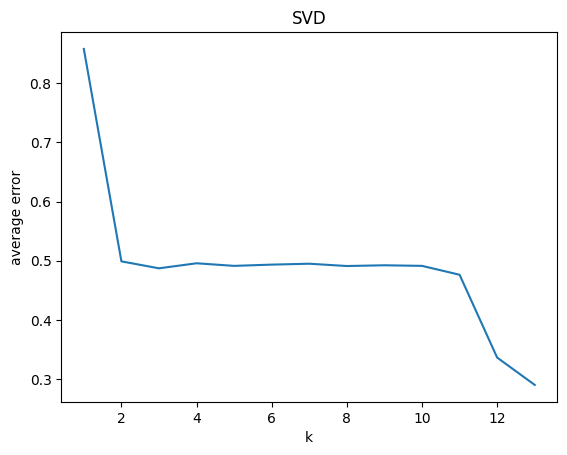

In [218]:
print(k_11)
print(dic)
plt.plot(dic.keys(), dic.values())
plt.xlabel('k')
plt.ylabel('average error')
plt.title('SVD')
plt.show()

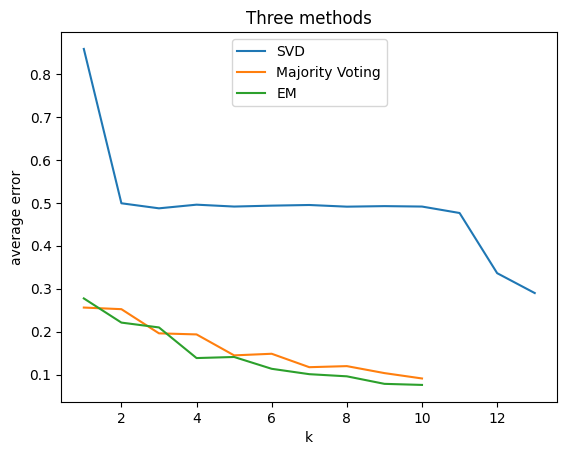

In [219]:
mv = {1: 0.25625, 2: 0.2525, 3: 0.19625, 4: 0.19375, 5: 0.145, 6: 0.14875, 7: 0.1175, 8: 0.12, 9: 0.10375, 10: 0.09125}
em = {1: 0.2775, 2: 0.22125, 3: 0.21, 4: 0.13875, 5: 0.14125, 6: 0.11375, 7: 0.10125, 8: 0.09625, 9: 0.07875, 10: 0.07625}
plt.plot(dic.keys(), dic.values(), label="SVD")
plt.plot(mv.keys(), mv.values(), label="Majority Voting")
plt.plot(em.keys(), em.values(), label="EM")
plt.xlabel('k')
plt.ylabel('average error')
plt.title('Three methods')
leg = plt.legend(loc='upper center')
plt.show()